In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import pandas as pd
import vice
import seaborn as sns


from scipy.stats import binned_statistic
from scipy.integrate import quad
from scipy.interpolate import interp1d, interp2d, CubicSpline
from scipy.optimize import curve_fit
import scipy

using vice version  1.4.0.dev1


In [3]:
import surp
from surp.analysis.vice_model import vice_model
import surp.analysis.apogee_analysis as aah
from surp.analysis import plotting_utils as pluto


import arya


In [4]:
df = aah.subgiants
filt = ~np.isnan(df["MG_H"])
filt &= ~np.isnan(df["C_MG"])
subgiants = df[filt].copy() #low alpha is closer to equilibrium

subgiants["C_MG_ERR"] = subgiants["C_FE_ERR"] + subgiants["MG_FE_ERR"]
subgiants["N_MG_ERR"] = subgiants["MG_FE_ERR"] + subgiants["N_FE_ERR"]
subgiants["C_N_ERR"] = subgiants["N_FE_ERR"] + subgiants["C_FE_ERR"]

In [5]:
def translate_label(s):
    return "[" + s.lower().replace("_", "/").replace("mg", "o") + "]"

In [6]:
def find_model(name):
    """
    Finds the pickled model with either the given name or the parameters 
    and returns the vice_model object
    """
    
    file_name = "../out/" + name + ".json"
    return vice_model(file_name)


In [7]:
def binned_stats(x, y, yerr=None, bins=30, range=(-0.4, 0.4), err_mean=False):
    
    counts, edges, _ = binned_statistic(x, y, bins=bins, range=range, statistic="count")
    
    means, _, _ = binned_statistic(x, y, bins=bins, range=range, statistic="median")
    stds, _, _ = binned_statistic(x, y, bins=bins, range=range, 
                                  statistic=lambda x: scipy.stats.median_abs_deviation(x, scale="normal"))
    errs = stds   
    xs = (edges[:-1] + edges[1:])/2
    return xs, means, errs

In [8]:
s0 = 5

def zooh_data(y="C_MG", ax=None, **kwargs):
    """
    Plots the mean trend of apogee subgiants
    
    ax: plot axis
    ele: y axis element
    params: passed to 
    
    """
    if ax is None:
        ax = plt.gca()
        
    df = subgiants[~subgiants.high_alpha]
    
    x, y, yerr = binned_stats(df.MG_H, df[y], df[y + "_ERR"])
    
    plt.scatter(x, y, color="k", s=s0)
    plt.scatter(x, y-yerr, marker="_", color="k", alpha=0.3, s=s0)
    plt.scatter(x, y+yerr, marker="_", color="k", alpha=0.3, s=s0)

    
def zoofe_data(y="C_MG", mg_0=-0.1, w=0.05, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    filt = subgiants["MG_H"] > mg_0 - w
    filt &= subgiants["MG_H"] < mg_0 + w
    df = subgiants[filt]

    x, y, yerr = binned_stats(subgiants.MG_FE, subgiants[y], subgiants[y + "_ERR"], range=[-0.05, 0.35])
    
    plt.scatter(x, y, color="k", s=s0)
    plt.scatter(x, y-yerr, marker="_", color="k", alpha=0.3, s=s0)
    plt.scatter(x, y+yerr, marker="_", color="k", alpha=0.3, s=s0)

In [9]:
def zooh_models(models, y="C_MG", ax=None):
    if ax is None:
        ax = plt.gca()
        
    name_0 = list(models.keys())[0]
    i = 0
    for name, model in models.items():
        xdat, ydat, yerr = binned_stats(model["[o/h]"], model[translate_label(y)], range=(-0.6, 0.6))
        ax.plot(xdat, ydat, label=name)

    zooh_data(y=y, zorder=-2)

def zoofe_models(models: dict, y="C_MG", mg_0=0.1, w=0.05, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    name_0 = list(models.keys())[0]


    for name, model in models.items():
        filt = model["[o/h]"] > mg_0 - w
        filt &= model["[o/h]"] < mg_0 + w
        df = model[filt]
        xdat, ydat, yerr = binned_stats(df["[o/fe]"], df[translate_label(y)], range=(-0.2, 0.4))
        ax.plot(xdat, ydat)
    
    zoofe_data(y=y, mg_0=mg_0, w=w, zorder=-2)

In [10]:
def compare(names, labels, y = "C_MG", ylabel="[C/Mg]", filename=None, ylim=(-0.3, 0.1)):
    models = {label: find_model(name).stars for name, label in zip(names, labels)}
    
    fig, axs = plt.subplots(1, 2, figsize=(7, 3.5), sharey=True)
    plt.subplots_adjust(wspace=0)

    plt.sca(axs[0])
    zooh_models(models, y=y)  

    plt.xlabel(f"[Mg/H]")
    plt.ylabel(ylabel)
    plt.xlim(-0.6, 0.6) 
    plt.ylim(ylim)
    plt.xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4])
    pluto.fancy_legend(ax=axs[0], colors=arya.style.COLORS)

    
    plt.sca(axs[1])
    zoofe_models(models, y=y)
    
    
    plt.xlabel(r"[Mg/Fe]")
    plt.ylabel(r"")
    plt.xlim(-0.15, 0.4)
    plt.title("")
    
    if filename is not None:
        plt.savefig(filename)


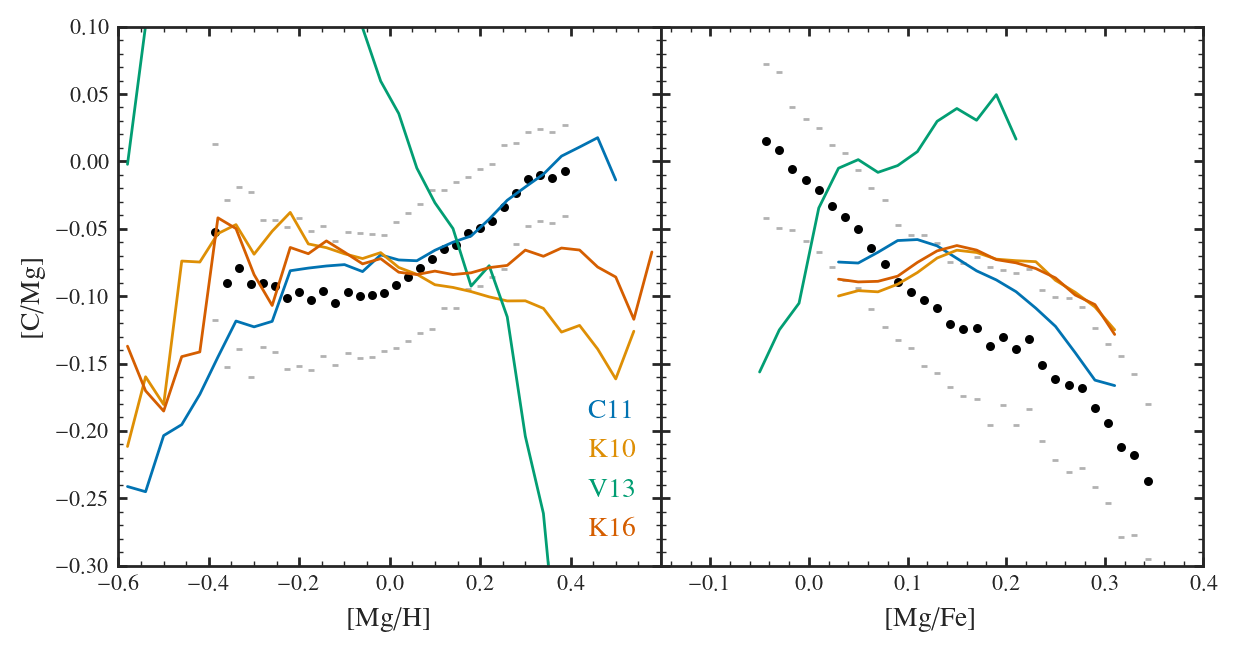

In [12]:
names = ["C11_f0.2_eta1_beta0.001",
        "K10_f0.2_eta1_beta0.001",
        "V13_f0.2_eta1_beta0.001",
        "K16_f0.2_eta1_beta0.001"]

labels = ["C11", "K10", "V13", "K16"]
compare(names, labels, filename="agb_oob.pdf")

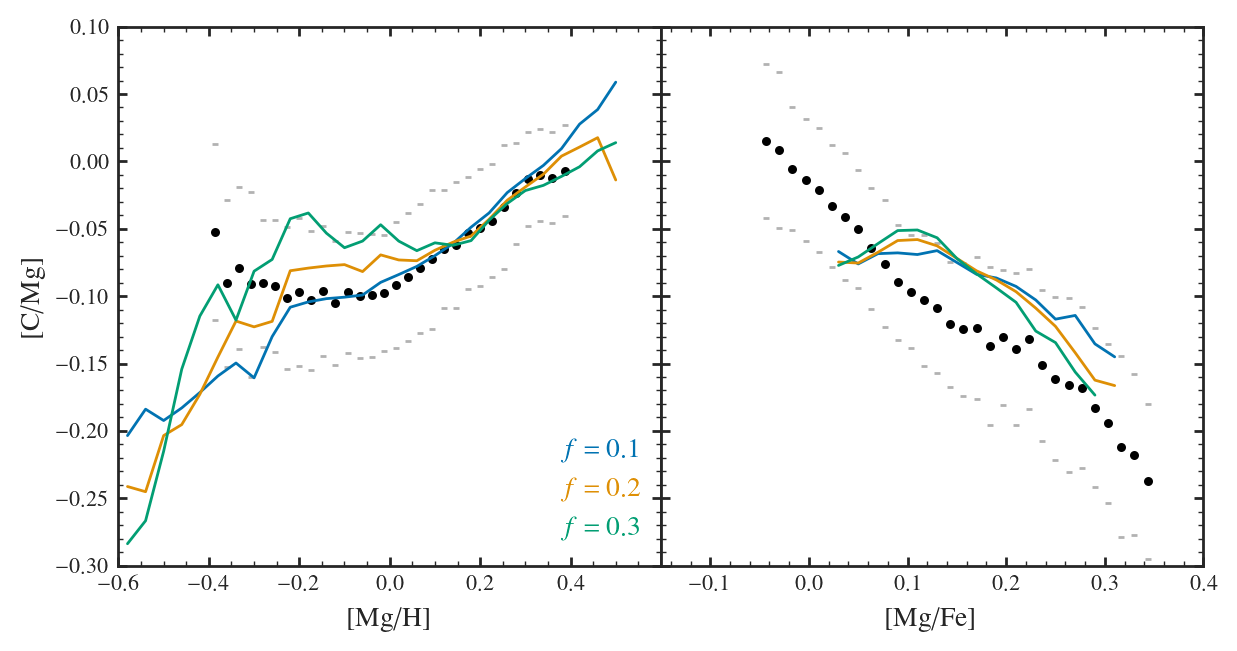

In [13]:
names = ["C11_f0.1_eta1_beta0.001", "C11_f0.2_eta1_beta0.001", "C11_f0.3_eta1_beta0.001"]

labels = ["$f=0.1$", "$f=0.2$", "$f=0.3$"]
compare(names, labels, filename="f_agb.pdf")

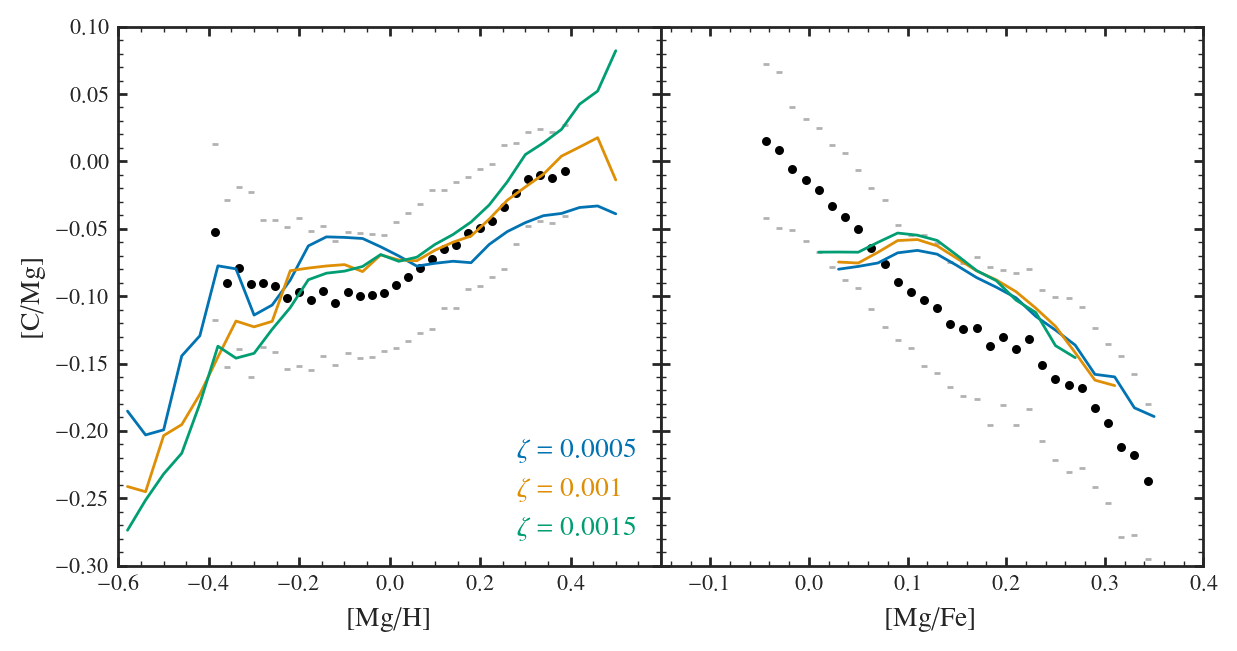

In [14]:

names = ["C11_f0.2_eta1_beta0.0005", "C11_f0.2_eta1_beta0.001", "C11_f0.2_eta1_beta0.0015"]

labels = [r"$\zeta=0.0005$", r"$\zeta=0.001$", r"$\zeta=0.0015$"]
compare(names, labels, filename="beta.pdf")


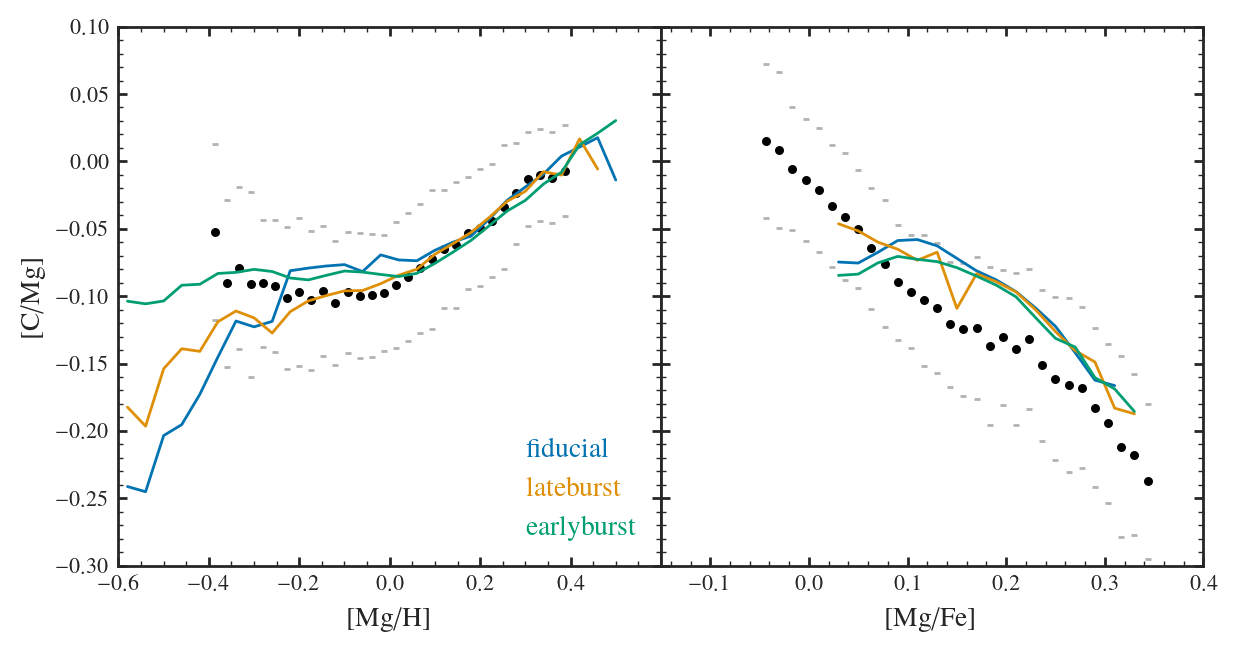

In [15]:
names = ["C11_f0.2_eta1_beta0.001", "C11_f0.2_eta1_beta0.001_lateburst1.5", "C11_f0.2_eta1_beta0.001_post-process"]

labels=["fiducial", "lateburst", "earlyburst"]
compare(names, labels, filename="lateburst_eta.pdf")


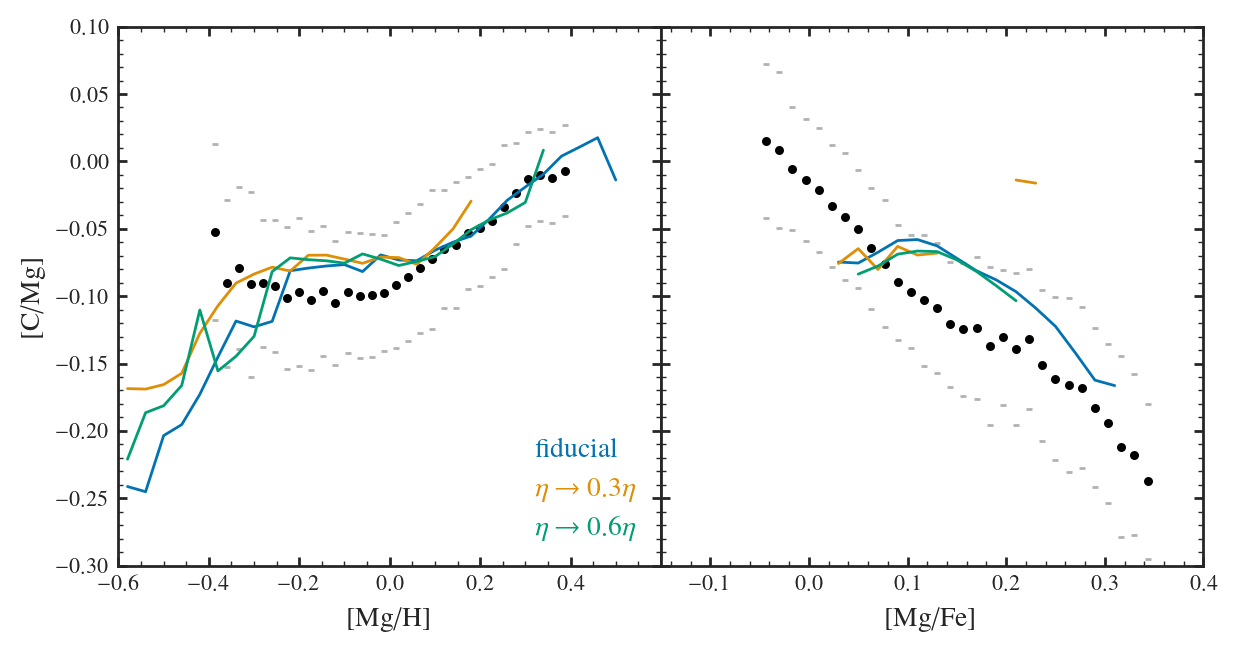

In [16]:
names = ["C11_f0.2_eta1_beta0.001", "C11_f0.2_eta0.3_beta0.001", "C11_f0.2_eta0.6_beta0.001"]

labels=["fiducial", r"$\eta\rightarrow0.3\eta$", r"$\eta\rightarrow0.6\eta$"]
compare(names, labels, filename="eta.pdf")

(-0.5, 0.4)

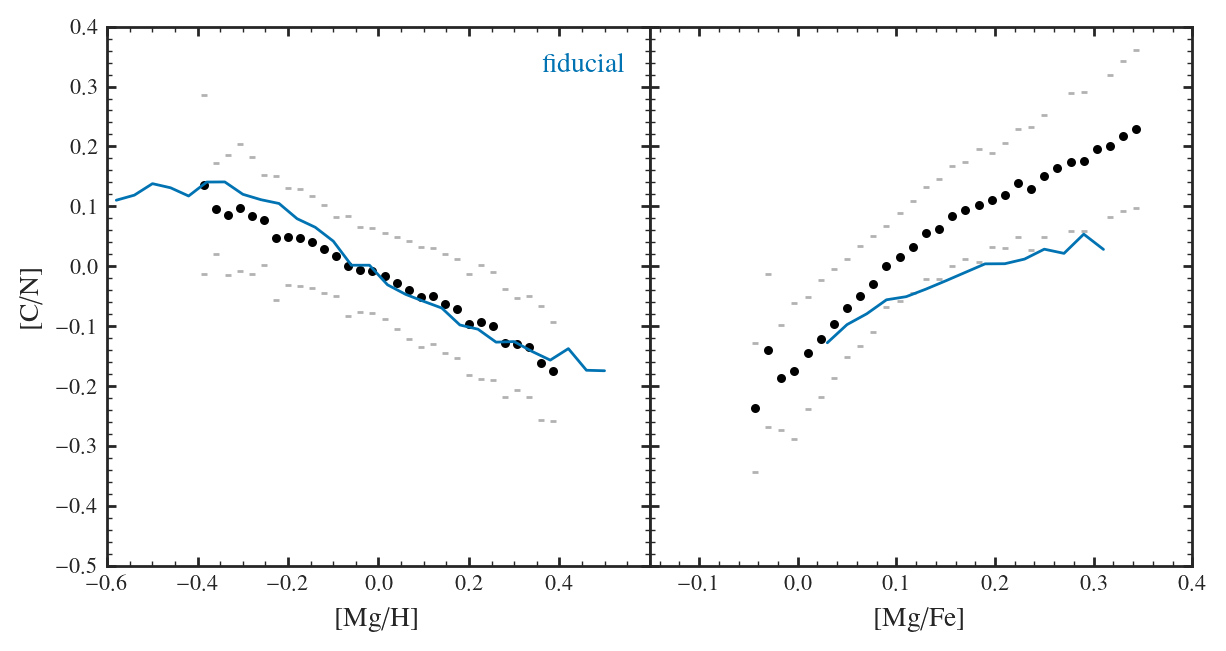

In [18]:
names = ["C11_f0.2_eta1_beta0.001", "C11_f0.2_eta1_beta0.001_twoexp0.5"]
labels = ["fiducial"]
compare(names, labels, y="C_N", filename="c_n.pdf", ylabel="[C/N]",  ylim=(-0.3, 0.4))
plt.ylim(-0.5, 0.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


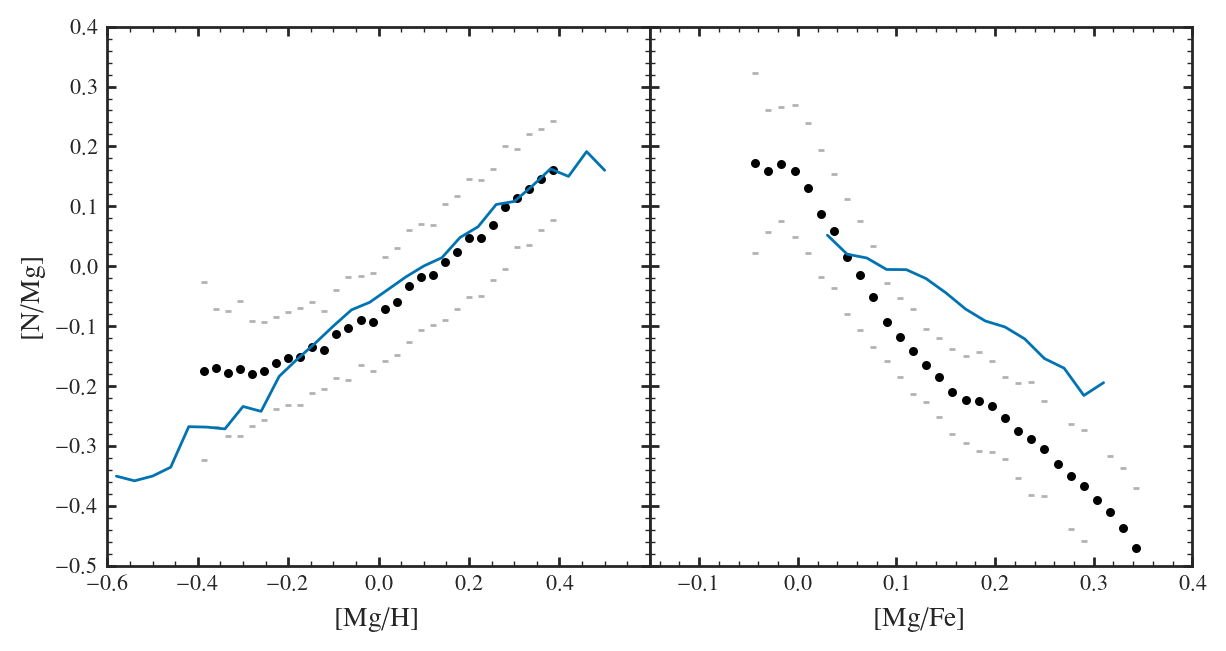

In [19]:
names = ["C11_f0.2_eta1_beta0.001", "C11_f0.2_eta1_beta0.001_twoexp0.5"]
labels = [""]
compare(names, labels, y="N_MG", filename="nitrogen.pdf", ylabel="[N/Mg]", ylim=(-0.5, 0.4))


(-1.0, 0.5)

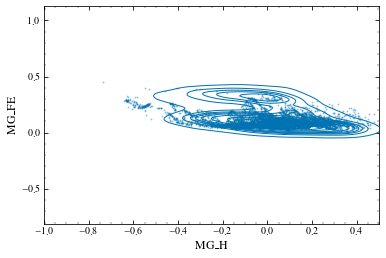

In [25]:
import seaborn as sns
df = find_model("C11_OOB_eta1_beta0.001")
plt.scatter(x=df["MG_H"], y=df["MG_FE"], s=1, alpha=0.3)
sns.kdeplot(x=subgiants.MG_H, y=subgiants.MG_FE);
plt.xlim(-1, 0.5)

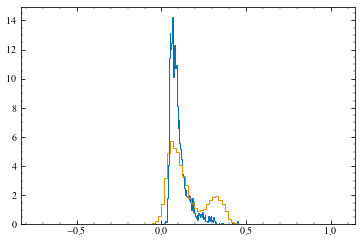

In [26]:
plt.hist(df["MG_FE"], 100, histtype="step", density=True)
plt.hist(subgiants["MG_FE"], 100, histtype="step", density=True);